## Week 11: My research - EMR analysis using RNN/LSTM model 

Instructor: Cornelia Ilin <br>
Email: cilin@ischool.berkeley.edu <br>

#### ``Objectives``

1. Introduction to <span style="color:chocolate">Electronic Medical Records</span> (EMR)
2. Predict the probability that the next hospital (overnight stay)/ER visit for a given patient is for respiratory/cardio condition v. injury accidents (binary classification task)
3. An **important feature** in my data is <span style="color:chocolate">pollution exposure</span> in the zip code at birth! (I instrument polution exposure using data on proximity to wildfires)
3. Use <span style="color:chocolate">RNN/LSTM</span> to model patient time series 
4. Post-prediction: counterfactual analysis for different values of pollution exposure at birth
5. Explore some ideas and techniques relevant to <span style="color:chocolate">fairness</span> in ML

#### ``Citations``

1. FareAware tasks inspired from this notebook:
    https://colab.research.google.com/github/google/eng-edu/blob/master/ml/cc/exercises/intro_to_ml_fairness.ipynb#scrollTo=dhKR49AT_5ZK

---
#### Electronic Medical Records (EMR)

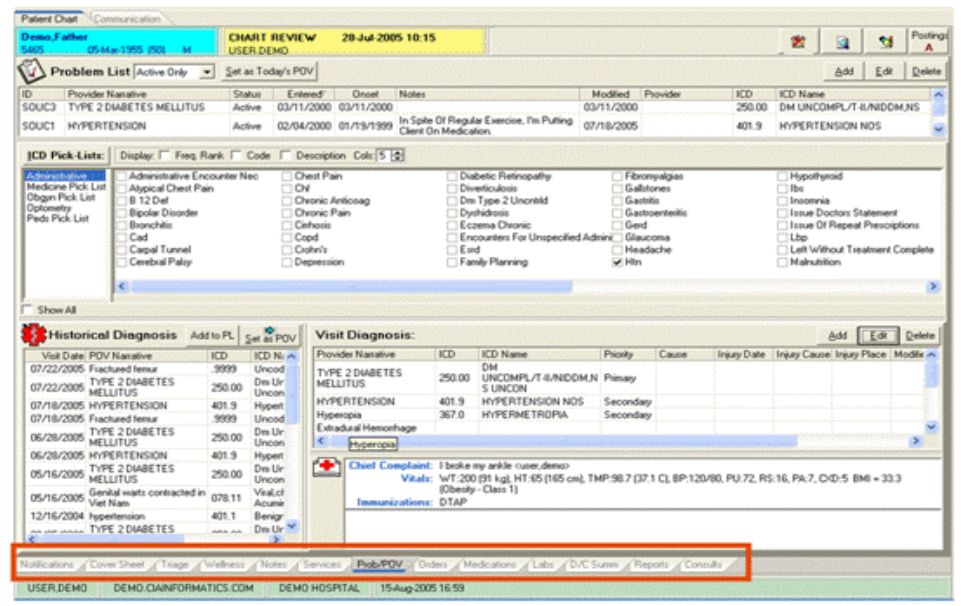

In [1]:
# Image source: https://uxpajournal.org/usability-of-electronic-medical-records/, accessed July 11, 2022
from IPython.display import Image
Image('./images/EMR.png', width=500)

``Types``

Electronical Medical Records (EMR) contain two types of data:

- structured (e.g., diagnosis codes, LDL values, etc), and
- unstructured (e.g., clinican notes, images, etc)

``My Data``

<span style="color:red">NO DATA AVAILABLE. Do not run this notebook!</span>

My medical data is HIPAA protected, and as a result, I had to go through a year-long approval process to get access to it. I cannot provide a dataset example to you due to confidentiality agreements. I will print two patient examples so you can understand the type of features I am working with.

**Time period**: 1991 to 2017. The data contains hospital(overnight stays)/ER visits at the patient level from birth to later in life (my oldest patient is 27 years old).

**Main variables**: Billing (ICD9 codes) and Demographics for each patient visit.

<span style="color:chocolate">Numeric features in my data</span>

*   **rlnI_***: Unique patient identifier
*   **age**: The age of the patient at time of hospital/ER visit (in years)
*   **pm25I_hat**: PM25 pollution in the ZIP code at birth (instrumented by proximity to wildfire exposure)
*   **visits_9mpp**: Number of times mother of patient visited the hospital in the pre-partum period (9 months before birth)
*   **visits_1ypp**: Number of times mother of patient visited the hospital in the post-partum period (12 months after birth)
*   **visits_1yol**: Number of times patient visited the hospital in the first year of life

<span style="color:chocolate">Categorical features in my data</span>

* **outcome**: Binary variable to denote if the hospital/ER visit is for resp/cardio (1) or injuries/accidents (0) conditions

* **sex**: Male (1) or Female (0)

*   **race**: Black, Hispanic, White, Native american/eskimo/aleut, Other

*   **meduc**: Education level for mother of patient (5 categories)

*   **cntyresI**: County of patient at time of birth

*   **patcnty**: County of patient at time of hospital/ER visit

*   **diag_***: ICD9/ICD10 diagnosis code at time of hospital/ER visit

<span style="color:chocolate">Prediction task</span>: to **determine what is the diagnosis in the next hospital visit** (binary classification task)

<span style="color:chocolate">Outcome label</span>: whether the person visits the hospital/ER fore resp/cardio condition (1) or injuries/accidents (0)

``Farirness in ML``

A few ideas:
   - increase awarness of different types of biases that can exist in your data
   - explore your features to identify potential sources of bias even before you run a predictive model
   - evaluate model performance by subgroup rather than aggregate (e.g., for different demographic groups)
   - perform counterfactual analysis for different subgroups

---
### Step 1: Import packages

In [3]:
# standard
import pandas as pd
import numpy as np
import os

# analysis
import patsy
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras import Input
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Masking
tf.keras.backend.set_floatx('float64')

# plots
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from PIL import Image

# metrics
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_curve, matthews_corrcoef

# statsmodels
import statsmodels.api as sm

# geography
import geopandas as gpd
import osmnx as ox
import shapely

# for facets
import base64
from IPython.core.display import display, HTML
#!pip install --user facets-overview==1.0.0
from facets_overview.feature_statistics_generator import FeatureStatisticsGenerator

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

C:\Users\cilin\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\cilin\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
<ipython-input-3-4cb5632e7fe7>:39: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


---
### Step 2: Define working directories

In [4]:
in_dir = ''

---
### Step 3: Define functions

``read data``

In [5]:
def read_data():
    return pd.read_csv(in_dir + 'analysis_data.csv')

``preprocess data``

In [6]:
def add_outcome(df, model):
    ''''''
    # rename outcome is "others" to 2 and 'B' to 3
    df['outcome'] = np.where(df.outcome.eq('others'), 2,
                    np.where(df.outcome.eq('B'), 3, df.outcome))

    df['outcome'] = df.outcome.astype(int)

    if model=='RC_vs_IA':
        # keep only if outcome is 0 or 1 (resp.cardio vs. injuries/accidents)
        df = df[df.outcome.isin((0, 1))]
        
    if model=='RC_vs_all':
        # keep only if outcome is 0 or 1 or 2 (injuries/accidents vs. others but birth) #exclude birth because of memory issues
        df = df[df.outcome.isin((0, 1, 2))]
        #recode to 0 and 1
        df['outcome'] = np.where(df.outcome.eq(1), 1, 0)
        
    df.reset_index(
        drop=True,
        inplace=True
    )
    
    return df

In [7]:
def add_features(df, add_pollut=True):
    ''''''
    # define data types
    df['admtyear'] = df.admtyear.astype(int)
    df['bthyearI'] = df.bthyearI.astype(int)
    df['pm25I'] = df['pm25I'].astype(float) # pm25 exposure at birth
    df['wfeI'] = df['wfeI'].astype(float)  # wildfire exposure at birth
    
    # add patient age
    df['age'] = df.admtyear - df.bthyearI
    
    # create admtyear_patcnty
    df['admtyear_patcnty'] = df.admtyear.astype(str).str.split('.').str[0] + '_' + df.patcnty.astype(str).str.split('.').str[0] 
    
    # create diagnosis 2D columns
    diag_2d = ['diag01', 'diag02', 'diag03', 'diag04']
    for col in diag_2d:
        # transform diag to string but leave np.nan if NaN (helps later on for dummy creation)
        df[col] = np.where(df[col].isna(), df[col], df[col].astype(str))
        df[col+'_2d'] = df[col].str[:2]
        
        
    # add rlnI_key variable (I need integers not strings)
    rlnI_keys = {key:idx+1 for idx, key in enumerate(df.rlnI_updated.unique())}
    df['rlnI_key'] = df.rlnI_updated.map(rlnI_keys)
    
    ###############
    ### DROP NA ###
    ###############
    # drop na but make sure to input the values (e.g., PM25 values)
    df = df.dropna(subset=['pm25I', 'wfeI', 'age'])

    # add one hot encodings
    sex_one_hot = pd.get_dummies(df['sexI'], drop_first=True)
    race_one_hot = (pd.get_dummies(df['raceI'], drop_first=False).drop(['native american/eskimo/aleut'], axis=1))
    #print('Race one hot', race_one_hot.shape)
    
    #patcnty_one_hot =  pd.get_dummies(df['admtyear_patcnty'], prefix='admtyear_patcnty', drop_first=True)
    patcnty_one_hot =  pd.get_dummies(df['patcnty'], prefix='patcnty', drop_first=True)
    cntyresI_one_hot =  pd.get_dummies(df['cntyresI'], prefix='cntyresI',drop_first=True)
    #print('County one hot', cntyresI_one_hot.shape)
    
    diag01_2d_one_hot = pd.get_dummies(df['diag01_2d'], prefix='diag', drop_first=True)
    diag02_2d_one_hot = pd.get_dummies(df['diag02_2d'], prefix='diag', drop_first=True)
    diag03_2d_one_hot = pd.get_dummies(df['diag03_2d'], prefix='diag', drop_first=True)
    diag04_2d_one_hot = pd.get_dummies(df['diag04_2d'], prefix='diag', drop_first=True)
    diag_2d_one_hot = pd.concat([diag01_2d_one_hot, diag02_2d_one_hot, diag03_2d_one_hot, diag04_2d_one_hot], axis=1)
    diag_2d_one_hot = diag_2d_one_hot.sum(axis=1, level=0, skipna=True)
    #print('Diag one hot', diag_2d_one_hot.shape)
    
    
    meduc_one_hot =  (pd.get_dummies(df['meduc'], prefix='meduc',drop_first=False).drop(['meduc_masters or phd'], axis=1))
        
    ## find pm25 hat ##
    ###################
     # create X and Y arrays
    y = df[['pm25I']]
    X = pd.concat([df[['wfeI', 'age', 'visitsM_9mpp', 'visitsM_1ypp', 'visitsI_1yol']], sex_one_hot, race_one_hot, meduc_one_hot, patcnty_one_hot, cntyresI_one_hot, diag_2d_one_hot], axis=1) # 'bthwghtI', 'bthwghtI2'

    # fit model
    fit_1st_stage = sm.OLS(y, X).fit()
    #print(fit_1st_stage.summary())
    
    # save pm25I_hat
    df['pm25I_hat'] = fit_1st_stage.get_prediction(X).summary_frame()['mean']
        
    if add_pollut:
        df = pd.concat(
            [df[['rlnI_updated', 'rlnI_key', 'outcome', 'age', 'pm25I_hat', 'visitsM_9mpp', 'visitsM_1ypp', 'visitsI_1yol']], sex_one_hot, race_one_hot, meduc_one_hot, patcnty_one_hot, cntyresI_one_hot, diag_2d_one_hot], 
            axis=1
        )
    else:
        df = pd.concat(
            [df[['rlnI_updated', 'rlnI_key', 'outcome', 'age', 'visitsM_9mpp', 'visitsM_1ypp', 'visitsI_1yol']], sex_one_hot, race_one_hot, meduc_one_hot, patcnty_one_hot, cntyresI_one_hot, diag_2d_one_hot],
            axis=1
        )
        
    df.reset_index(
        drop=True,
        inplace=True
    )
    
    return df

In [8]:
def add_padding(df, lb, up, time_steps, pad_value):
    '''
    lb is a lower bound to discard, ub is an upper bound to truncate on. All entries are padded to their ubber bound 
    '''
    
    # drop if patient doesn't have at least one hospital/ER visit
    df = df.groupby('rlnI_updated').filter(
        lambda group: len(group) > lb
    ).reset_index(drop=True)
    
    # drop if patient has more than **up** visits (up = time_steps)
    df = df.groupby('rlnI_updated').apply(
        lambda group: group[0:time_steps]
    ).reset_index(drop=True)
    
    # add padding if patient has less than **up** visits (up = time_steps)
    df = df.groupby('rlnI_updated').apply(
        lambda group: pd.concat([group, pd.DataFrame(pad_value*np.ones((time_steps-len(group), len(df.columns))), columns=df.columns)],
                                axis=0)
    ).reset_index(drop=True)
         
    return df

In [9]:
def create_X_y_arrays(df, time_steps, pad_value):
    '''
    '''
    # define target
    target = 'outcome'
    
    # define key
    rlnI_key = 'rlnI_key'
    
    # find columns in df
    COLUMNS = list(df.columns)
    
    # remove target
    COLUMNS.remove(target)
    
    # toss columns
    toss = ['rlnI_updated', 'rlnI_key']
    COLUMNS = [col for col in COLUMNS if col not in toss]
    
    # transform data to array
    MATRIX = df[[rlnI_key] + COLUMNS + [target]].values
        
    ## reshape data ##
    ##################
    # first dimension is the batch dimension (# of unique rlnI_updated)
    # second dimension is the sequence length (padded # of hospital/ER visits per patient),
    # third dimension is number of features (includes outcome here too but later on is excluded)
    MATRIX = MATRIX.reshape(
        int(MATRIX.shape[0]/time_steps), time_steps, MATRIX.shape[1]
    )
    
    ## Zscore normalize features ##
    ###############################
    # Padded time steps should be masked with np.nan
    # note we are creating a second order bool matrix
    bool_matrix = (~MATRIX.any(axis=2)) # turn to False anything that is padded
    MATRIX[bool_matrix] = np.nan # mask padded values with np.nan
    #MATRIX = ZScoreNormalize(MATRIX) # apply Zscore normalization
    ## restore 3D shape to boolmatrix for consistency (add back padded value instead of np.nan)
    bool_matrix = np.isnan(MATRIX)
    MATRIX[bool_matrix] = pad_value 
    
    ## create X and y arrays ##
    ###########################
    # shuffle the first dimension (patients)
    np.random.seed(12)
    permutation = np.random.permutation(MATRIX.shape[0])
    MATRIX = MATRIX[permutation]
    # now create X and y arrays
    rlnI_MATRIX = MATRIX[:,:,0:1]
    X_MATRIX = MATRIX[:,:,1:-1]
    y_MATRIX = MATRIX[:,:,-1] 
    
    ## create boolean X and y arrays ##
    ###################################
    # create FALSE/TRUE entries. FALSE if no padding, TRUE if padding
    bool_matrix = bool_matrix[permutation]
    rlnI_bool_matrix = bool_matrix[:,:,0:1]
    x_bool_matrix = bool_matrix[:,:,1:-1]
    y_bool_matrix = bool_matrix[:,:,-1]
    
    
    return X_MATRIX, y_MATRIX, x_bool_matrix, y_bool_matrix, rlnI_MATRIX, rlnI_bool_matrix, COLUMNS

In [10]:
def ZScoreNormalize(matrix):

    ''' Performs Z Score Normalization for 3rd order tensors 
        matrix should be (batchsize, time_steps, features) 
        Padded time steps should be masked with np.nan '''
    rlnI_matrix = matrix[:,:,0:1]
    x_matrix = matrix[:,:,1:-1]
    y_matrix = matrix[:,:,-1]
    
    rlnI_matrix = rlnI_matrix.reshape(rlnI_matrix.shape[0], rlnI_matrix.shape[1],1)
    y_matrix = y_matrix.reshape(y_matrix.shape[0],y_matrix.shape[1],1)
    means = np.nanmean(x_matrix, axis=(0,1))
    stds = np.nanstd(x_matrix, axis=(0,1))
    x_matrix = x_matrix-means
    x_matrix = x_matrix / stds
    matrix = np.concatenate([rlnI_matrix, x_matrix, y_matrix], axis=2)

    return matrix

In [11]:
def split_data(X, y, X_bool_matrix, y_bool_matrix, rlnI, rlnI_bool_matrix ,train_split_percentage, val_split_percentage):
    """
    Args:
        X: features of whole dataset
        y: labels of whole dataset
        train_split_percentage: percentage of data that belongs to the train set
        val_split_percentage: percentage of data that belongs to validation set

    Returns:
        (train_x, train_y): the training set
        (val_x, val_y): the validation set
        (test_x, test_y): the test set
    """
    # create empty objects
    train_x, train_y, val_x, val_y, test_x, test_y = None, None, None, None, None, None
    
    # create train data
    train_x = X[0:int(train_split_percentage*X.shape[0]),:,:]
    train_y = y[0:int(train_split_percentage*y.shape[0]),:]
    train_rlnI = rlnI[0:int(train_split_percentage*rlnI.shape[0]),:]
    
    train_y = train_y.reshape(train_y.shape[0], train_y.shape[1], 1)
    train_rlnI = train_rlnI.reshape(train_rlnI.shape[0], train_rlnI.shape[1], 1)
    
    # create val data
    val_x = X[
        int(train_split_percentage*X.shape[0]):int((train_split_percentage + val_split_percentage)*X.shape[0])
    ]
    
    val_y = y[
        int(train_split_percentage*y.shape[0]):int((train_split_percentage + val_split_percentage)*y.shape[0])
    ]
    
    val_rlnI = rlnI[
        int(train_split_percentage*rlnI.shape[0]):int((train_split_percentage + val_split_percentage)*rlnI.shape[0])
    ]
    
    val_y = val_y.reshape(val_y.shape[0], val_y.shape[1], 1)
    val_rlnI = val_rlnI.reshape(val_rlnI.shape[0], val_rlnI.shape[1], 1)

    # create test data
    test_x = X[int((train_split_percentage + val_split_percentage)*X.shape[0])::]
    test_y = y[int((train_split_percentage + val_split_percentage)*y.shape[0])::]
    test_rlnI = rlnI[int((train_split_percentage + val_split_percentage)*rlnI.shape[0])::]
    
    test_y = test_y.reshape(test_y.shape[0], test_y.shape[1], 1)
    test_rlnI = test_rlnI.reshape(test_rlnI.shape[0], test_rlnI.shape[1], 1)
    
    ## create boolmat versions for validation and test ##
    #####################################################
    # validation
    val_x_boolmat = X_bool_matrix[
        int(train_split_percentage*X_bool_matrix.shape[0]): \
        int((train_split_percentage + val_split_percentage)*X_bool_matrix.shape[0])
    ]
    
    val_y_boolmat = y_bool_matrix[
        int(train_split_percentage*y_bool_matrix.shape[0]): \
        int((train_split_percentage + val_split_percentage)*y_bool_matrix.shape[0])
    ]
    
    val_rlnI_boolmat = rlnI_bool_matrix[
        int(train_split_percentage*rlnI_bool_matrix.shape[0]): \
        int((train_split_percentage + val_split_percentage)*rlnI_bool_matrix.shape[0])
    ]

    val_y_boolmat = val_y_boolmat.reshape(val_y_boolmat.shape[0], val_y_boolmat.shape[1],1)
    val_rlnI_boolmat = val_rlnI_boolmat.reshape(val_rlnI_boolmat.shape[0], val_rlnI_boolmat.shape[1],1)
    
    # test
    test_x_boolmat = X_bool_matrix[
        int((train_split_percentage + val_split_percentage)*X_bool_matrix.shape[0])::
    ]
    
    test_y_boolmat = y_bool_matrix[
        int((train_split_percentage + val_split_percentage)*y_bool_matrix.shape[0])::
    ]
    
    test_rlnI_boolmat = rlnI_bool_matrix[
        int((train_split_percentage + val_split_percentage)*rlnI_bool_matrix.shape[0])::
    ]
    
    test_y_boolmat = test_y_boolmat.reshape(test_y_boolmat.shape[0],test_y_boolmat.shape[1],1)
    test_rlnI_boolmat = test_rlnI_boolmat.reshape(test_rlnI_boolmat.shape[0],test_rlnI_boolmat.shape[1],1)
    

    #print(train_x.shape, train_y.shape, val_x.shape, val_y.shape, test_x.shape, test_y.shape)
    return train_x, train_y, val_x, val_y, test_x, test_y,\
           val_x_boolmat, val_y_boolmat, test_x_boolmat, test_y_boolmat, \
           train_rlnI, val_rlnI, test_rlnI, val_rlnI_boolmat, test_rlnI_boolmat 

``metrics``

In [ ]:
# I put all the functions in a separate file
import plots

``analysis``

In [12]:
# [move model functions here]

---
### Step 4 : Read data

In [13]:
# read and preprocess data
df_init = read_data()
#df_init.head(2)

In [14]:
# avoid ICD10 codes (remove any hospital visits after Jan 1, 2015)
# i.e., focus only on ICD9 codes
df_init.dropna(subset=['admtmonth', 'admtyear'], inplace=True)

df_init['admtmonth'] = df_init.admtmonth.astype(int)
df_init['admtyear'] = df_init.admtyear.astype(int)

df_init = df_init[~(df_init.admtmonth.ge(1) & df_init.admtyear.ge(2015))]
print('Shape of data:', df_init.shape)

Shape of data: (3736317, 194)


``select a small sample at random`` (e.g., time series of XXX SSN numbers)

In [15]:
np.random.seed(12)

# find unique rlnIs
rlnIs = df_init.rlnI_updated.unique()

n = 300000 # for 300000 random indices
index = np.random.choice(rlnIs.shape[0], n, replace=False)  

rlnIs_random = rlnIs[index]
df_init2 = df_init[df_init.rlnI_updated.isin(rlnIs_random)]
print('Shape of df    ', df_init2.shape)

df_init2.reset_index(drop=True, inplace=True)


Shape of df     (1467410, 194)


---
### Step 5: Define params

In [16]:
# define argument values
lower_bound = 0
upper_bound = 3
time_steps = upper_bound
pad_val = 0
train_split = 0.7
val_split = 0.1
add_pollution=True

---
### Step 6: Preprocess + EDA with <span style="color:chocolate">fairness</span> in mind


``add outcome and features``

In [17]:
def_outcome = 'RC_vs_IA' # resp/cardio vs. injuries/accidents
df = add_outcome(df_init2, def_outcome) 
df = add_features(df, add_pollution)
print('Shape of data:', df.shape)

print('\nPrinting 2 patients in my data...')
df[df.rlnI_updated.isin(('0000OO0NS', '0000OO0OU'))]

Shape of data: (545934, 245)

Printing 2 patients in my data...


rlnI_updated  rlnI_key  outcome  age  pm25I_hat  visitsM_9mpp  visitsM_1ypp  \
1    0000OO0NS         3        1    1  11.204266           1.0           0.0   
2    0000OO0NS         3        0   10  12.400503           1.0           0.0   
3    0000OO0NS         3        0   14  13.180446           1.0           0.0   
4    0000OO0OU         4        1    0  13.278497           0.0           0.0   
5    0000OO0OU         4        1    2  13.668469           0.0           0.0   

   visitsI_1yol  M  asian/pacific islander  ...  diag_V8  diag_V9  diag_16  \
1           1.0  0                       0  ...        0        0        0   
2           1.0  0                       0  ...        0        0        0   
3           1.0  0                       0  ...        0        0        0   
4           1.0  0                       0  ...        0        0        0   
5           1.0  0                       0  ...        0        0        0   

   diag_63  diag_65  diag_66  diag_Z9  diag_14  diag_N3  diag_Q6  
1        0        0        0        0        0        0        0  
2        0        0        0        0        0        0        0  
3        0        0        0        0        0        0        0  
4        0        0        0        0        0        0        0  
5        0        0        0        0        0        0        0  

[5 rows x 245 columns]

In [18]:
print('Columns in my data: ', [col for col in df.columns])

Columns in my data:  ['rlnI_updated', 'rlnI_key', 'outcome', 'age', 'pm25I_hat', 'visitsM_9mpp', 'visitsM_1ypp', 'visitsI_1yol', 'M', 'asian/pacific islander', 'black', 'hisp', 'other', 'unknown', 'white', 'meduc_college (1-3 years)', 'meduc_college (4 years)', 'meduc_high school or less', 'meduc_unknown or other', 'patcnty_1.0', 'patcnty_2.0', 'patcnty_3.0', 'patcnty_4.0', 'patcnty_5.0', 'patcnty_6.0', 'patcnty_7.0', 'patcnty_8.0', 'patcnty_9.0', 'patcnty_10.0', 'patcnty_11.0', 'patcnty_12.0', 'patcnty_13.0', 'patcnty_14.0', 'patcnty_15.0', 'patcnty_16.0', 'patcnty_17.0', 'patcnty_18.0', 'patcnty_19.0', 'patcnty_20.0', 'patcnty_21.0', 'patcnty_22.0', 'patcnty_23.0', 'patcnty_24.0', 'patcnty_25.0', 'patcnty_26.0', 'patcnty_27.0', 'patcnty_28.0', 'patcnty_29.0', 'patcnty_30.0', 'patcnty_31.0', 'patcnty_32.0', 'patcnty_33.0', 'patcnty_34.0', 'patcnty_35.0', 'patcnty_36.0', 'patcnty_37.0', 'patcnty_38.0', 'patcnty_39.0', 'patcnty_40.0', 'patcnty_41.0', 'patcnty_42.0', 'patcnty_43.0', 'pat

### <span style="color:chocolate">FairAware Task #1</span>

It is important to preprocess and review descriptive statistics and histograms for each numerical and continuous feature. 

Then, try to answer the following questions:
1. What is the patient location at birth? Are they distributed according to statistics in the population?
2. Is the outcome variable balanced across the two classes we want to predict?
3. Are there missing feature values for a large number of observations?
4. Are there features that are missing that might affect other features?
5. Are there any unexpected feature values?
6. What signs of data skew do you see?

``1. patient location at birth``

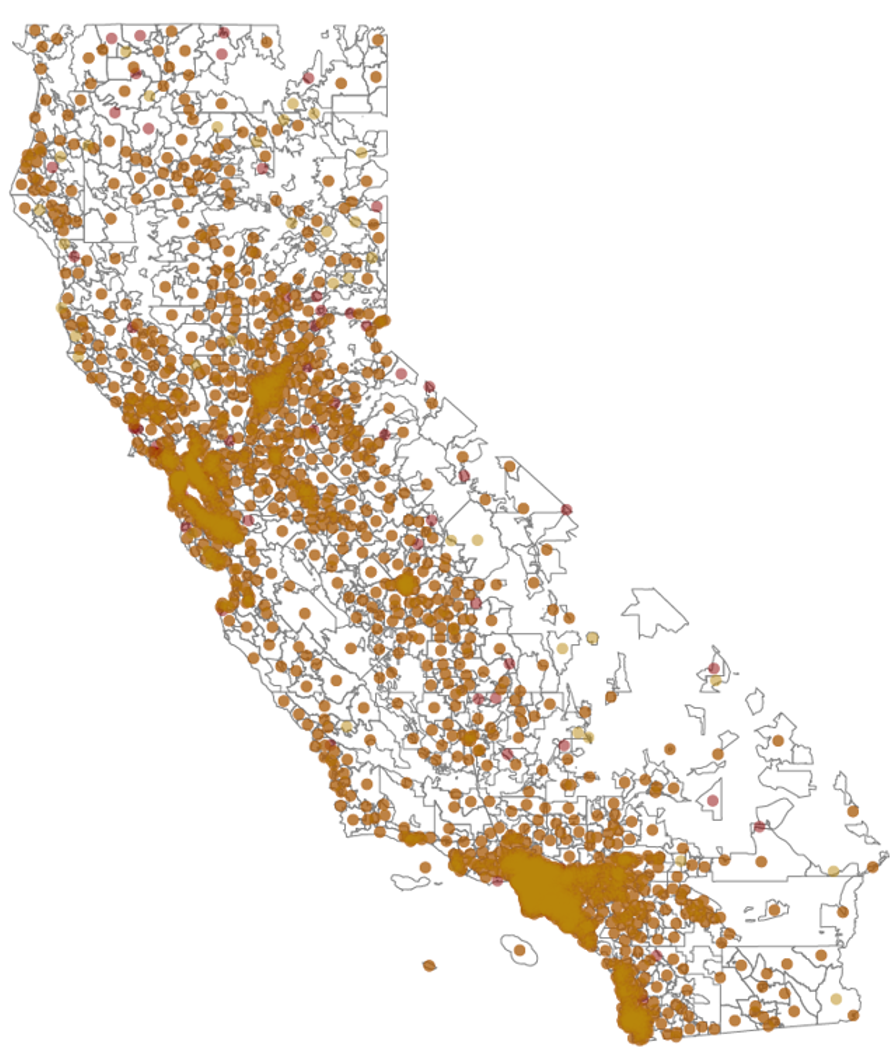

In [19]:
from IPython.display import Image
Image('./images/location.png', width=350)

``2. check for class imbalance``

<AxesSubplot:>

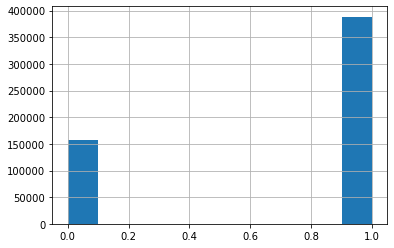

In [20]:
df.outcome.hist()

In [21]:
neg, pos = np.bincount(df['outcome'])
neg_rlnI = df[df.outcome.eq(0)].rlnI_key.nunique()
pos_rlnI = df[df.outcome.eq(1)].rlnI_key.nunique()
total = neg + pos
print('Examples:\n \
      Total: {}\n \
      Negative: {}\n \
      Negative rlnI: {}\n \
      Positive: {} ({:.2f}% of total)\n \
      Positive rlnI: {}\n'.format(
    total, neg, neg_rlnI, pos, 100 * pos / total, pos_rlnI))

Examples:
       Total: 545934
       Negative: 157333
       Negative rlnI: 95192
       Positive: 388601 (71.18% of total)
       Positive rlnI: 157258



Clearly, the data we have is inbalanced: the positive class represents more than 60 percent of the total observations.

We are going to correct for class imbalance by undersampling the positive class. Note, that we do the balancing at the invidual identifier level, because we don't want to eliminate part of the time series for a given individual.

In [22]:
temp_positive = df[df.outcome.eq(1)].rlnI_key.sample(
    n=int(neg_rlnI*(1-0.9)),
    replace=False
)

temp_negative = df[df.outcome.eq(0)].rlnI_key.sample(
    n=neg_rlnI,
    replace=False
)


df = pd.concat(
    [
        df[df.rlnI_key.isin(temp_positive)],
        df[df.rlnI_key.isin(temp_negative)]
    ],
    axis=0
)

Let's plot the class distribution again to see if we deal with a more balanced dataset now.

Shape of data: (314301, 245)


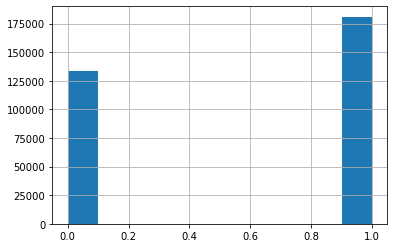

In [23]:
df.outcome.hist()
print('Shape of data:', df.shape)

All patients in my dataset were born in California.

``3. missing feature values for a large number of observations?``

check distribution of pollution exposure in the zip code at birth

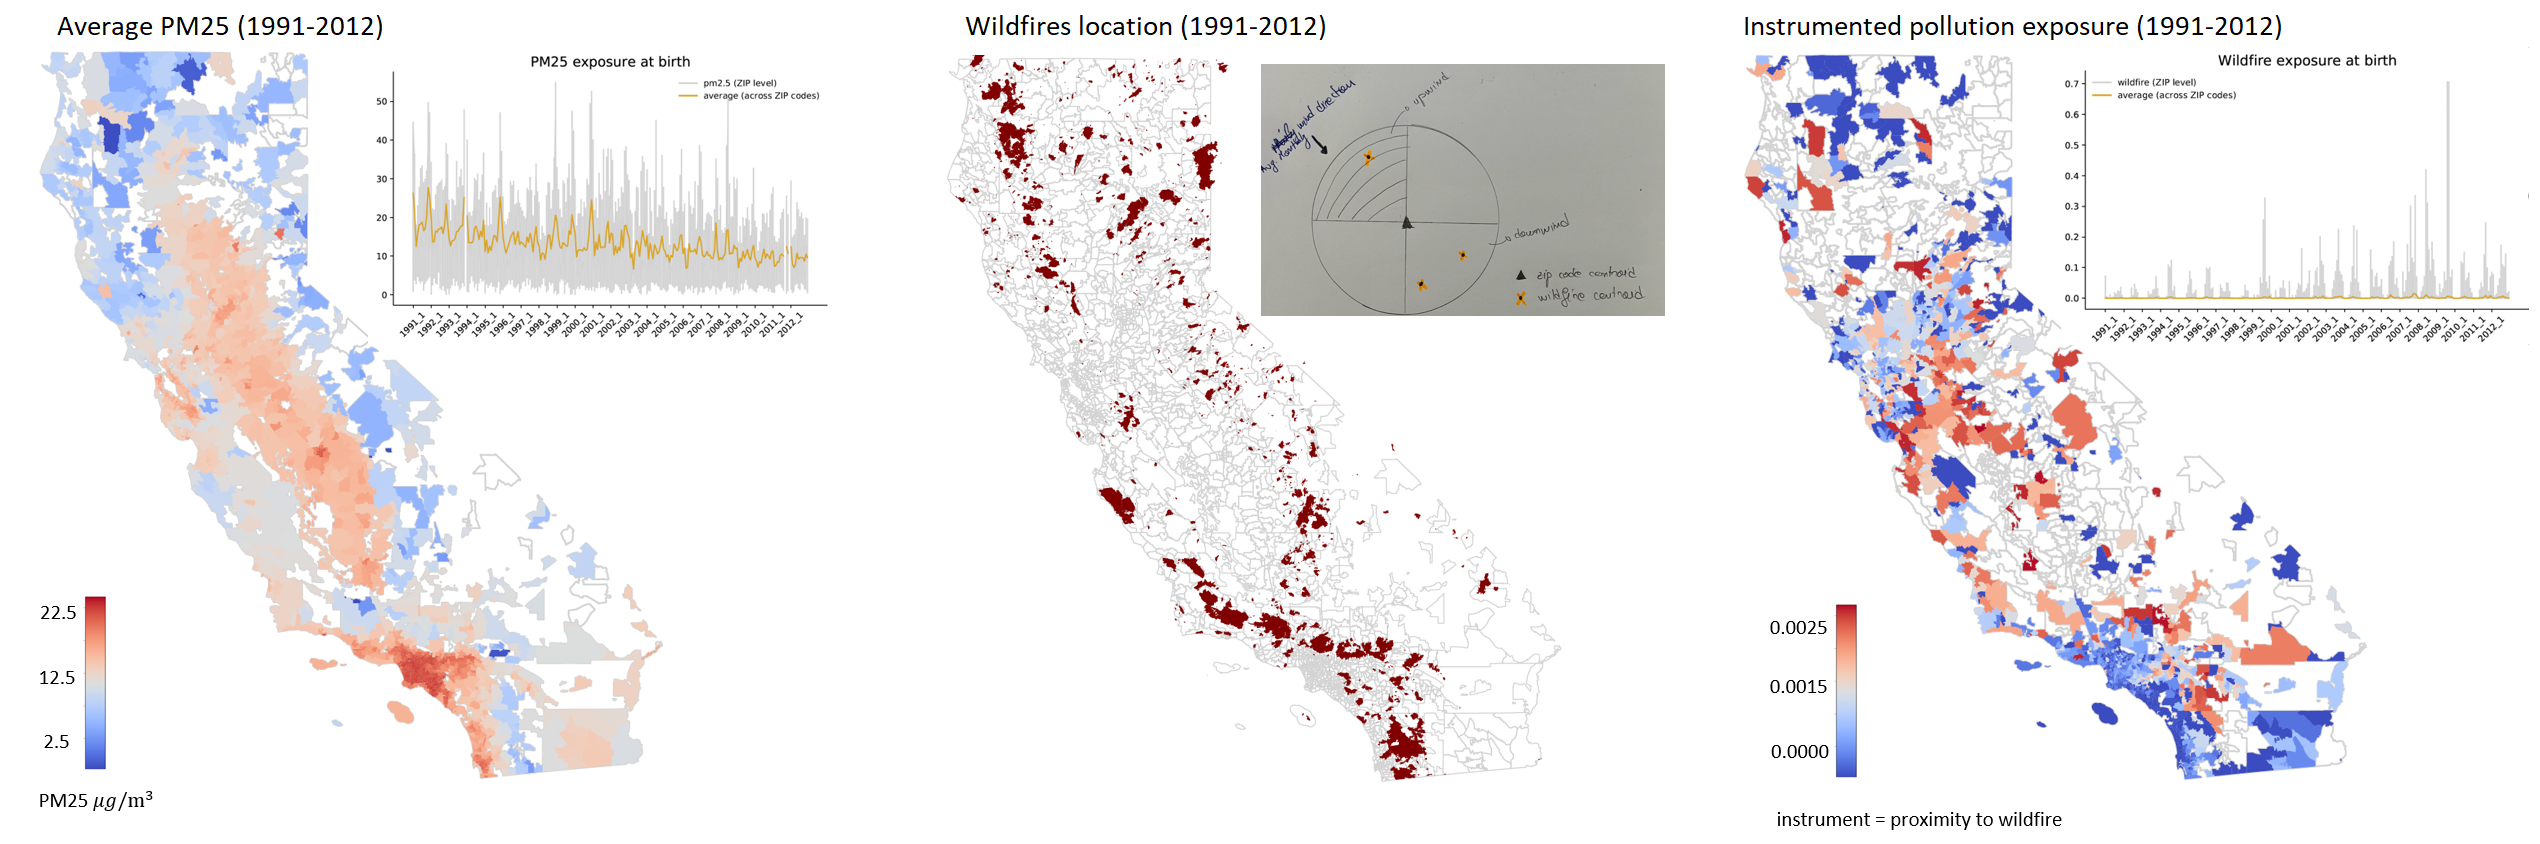

In [24]:
from IPython.display import Image
Image('./images/pollution_exposure.png', width=1100)

Next, we are going to use [Facets Overview](https://pair-code.github.io/facets/), an interactive visualization tool that can help us explore in more detail other features in the dataset.

In [25]:
# visualize the Data in Facets
fsg = FeatureStatisticsGenerator()
dataframes = [
    {'table': df.iloc[:,1:30], 'name': 'Data'}]  #visualize first 30 features only
censusProto = fsg.ProtoFromDataFrames(dataframes)
protostr = base64.b64encode(censusProto.SerializeToString()).decode("utf-8")

HTML_TEMPLATE = """<script src="https://cdnjs.cloudflare.com/ajax/libs/webcomponentsjs/1.3.3/webcomponents-lite.js"></script>
        <link rel="import" href="https://raw.githubusercontent.com/PAIR-code/facets/1.0.0/facets-dist/facets-jupyter.html">
        <facets-overview id="elem"></facets-overview>
        <script>
          document.querySelector("#elem").protoInput = "{protostr}";
        </script>"""
html = HTML_TEMPLATE.format(protostr=protostr)
display(HTML(html))

Findings:<br>
   - no missing values for a large number of features (I cleaned the data pretty well)
   - no features that are missing that might affect other features
   - no unexpected feature values (I cleaned the data extensively)
   - if we look at the min/max values and histograms for each numeric feature, then we can pinpoint some (extreme) outliers in our data (e.g., age, visitsM_9mpp, visitsM_1ypp, visitsI_1yol
   - in looking at the histogram for gender, we see that over two-thirds (approximately 58%) of examples represent males. This suggests some data skew, i.e., <span style="color:chocolate">females are slightly underrepresented in the data</span> (we would expect the breakdown between genders to be closer to 50/50).
   - what can we say about the histogram for race and mother education level?

### <span style="color:chocolate">FairAware Task #2</span>

Plot the following graphs to show the relationship between:
- outcome and age
- outcome and sex
- outcome and race
- outcome and mother education

What noteworthy observations can you make about these distributions? Keep the following fairness-related questions in mind:

1. What's missing?
2. What's being overgeneralized?
3. What's being underrepresented?
4. How do the variables, and their values, reflect the real world?
5. What might we be leaving out?

I used [Facets Dive](https://pair-code.github.io/facets/) to further explore the dataset, it's a tool that provides an interactive interface

``outcome and age``

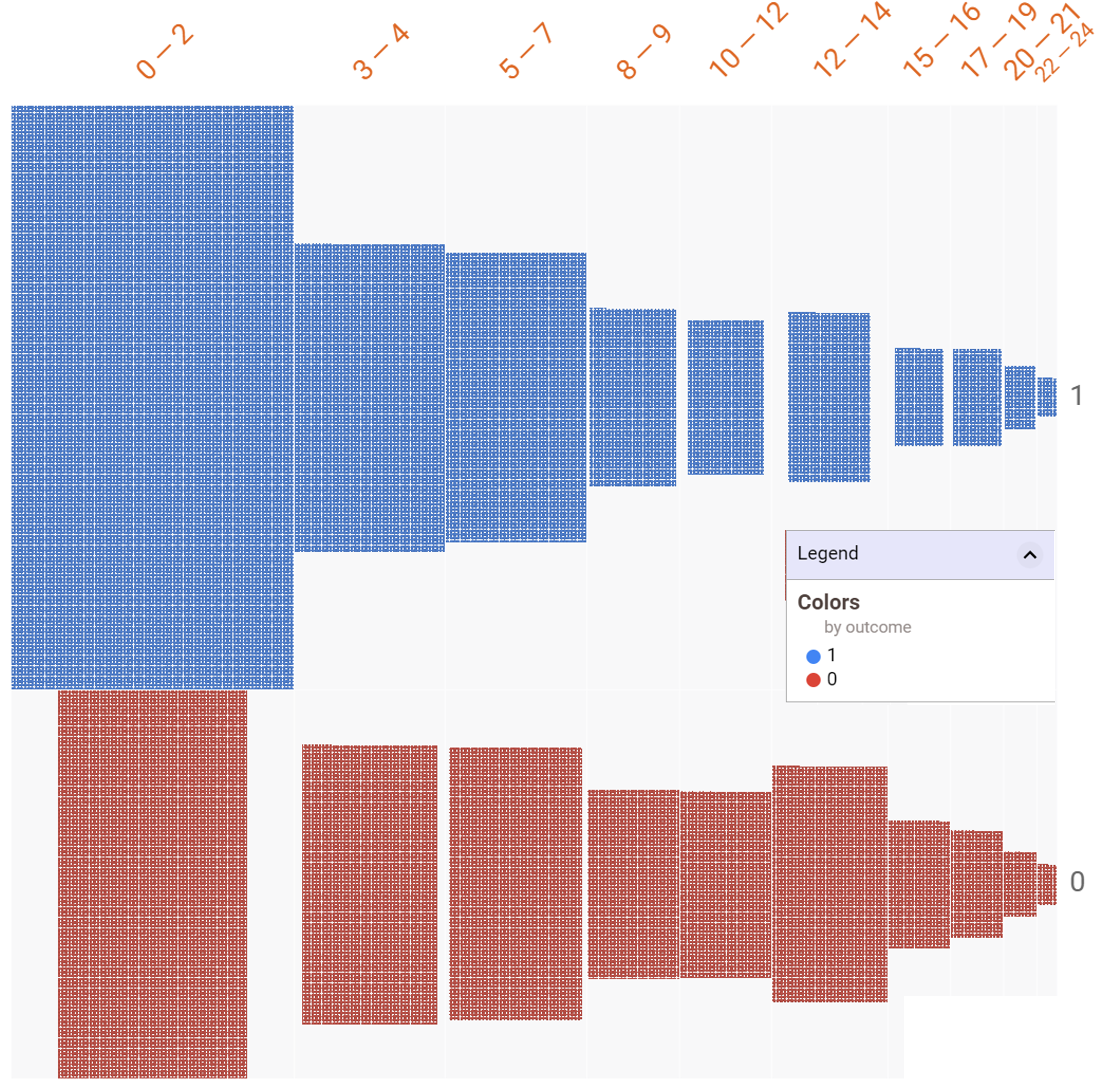

In [26]:
from IPython.display import Image
Image('./images/age_by_outcome.png', width=400)

In this sample, 0-2 yold patients tend to be diagnosed with a respiratory/cardio condition more often.

^ With fairness in mind, how would you address the skewed distribution by age?  Answer: Bucketing (also known as binning): group together similar ages into different groups (this might help the model generalize better across age).

``outcome and sex``

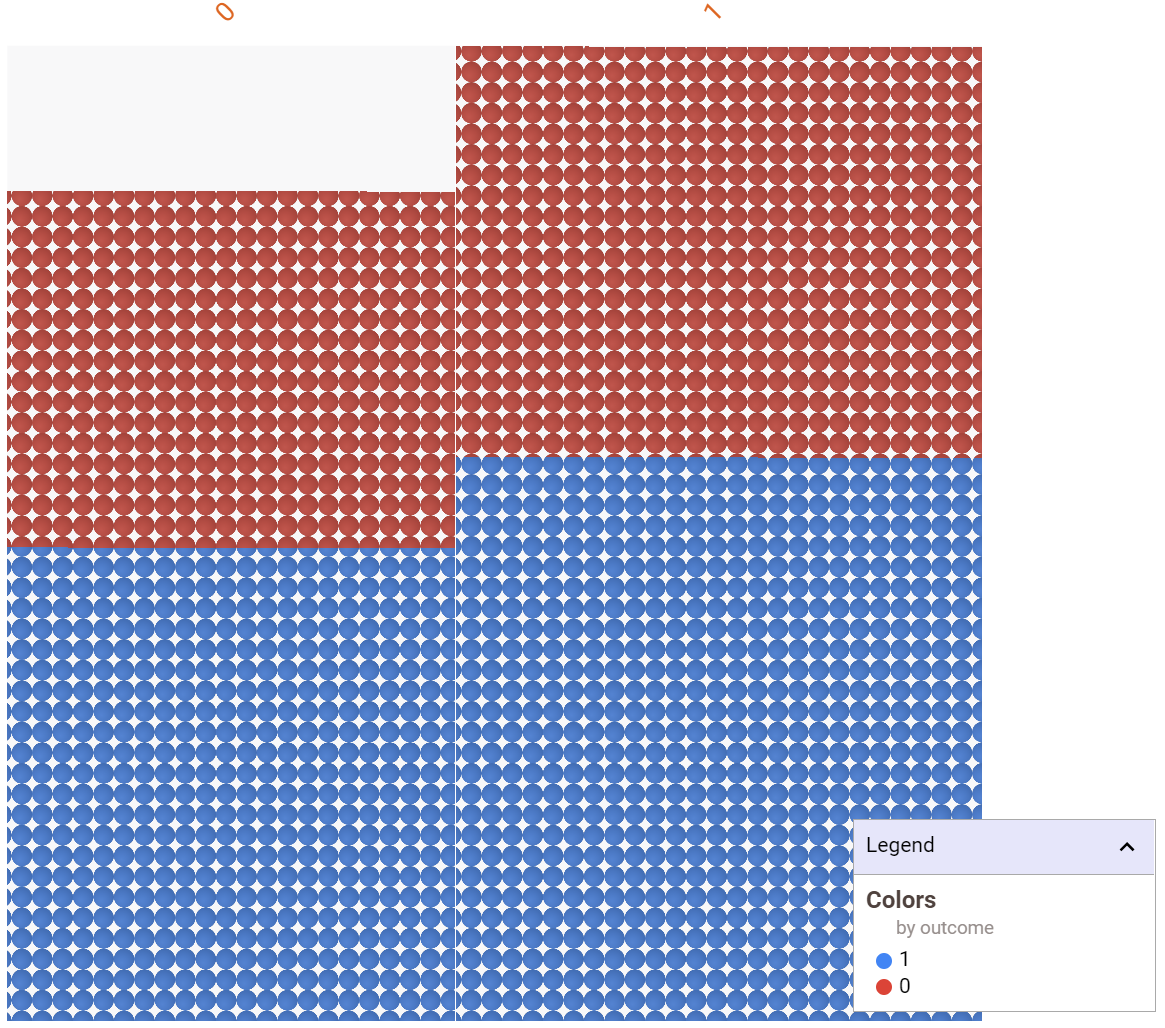

In [27]:
from IPython.display import Image
Image('./images/sex_by_outcome.png', width=400)
# 0 = Female, 1 = Male

Given that we already discovered in Task #1 that there is a higher representation of men in the data set, we can now infer that it's females from both outcome categories that are underrepresented in the data.

^ With fairness in mind, how would you address the skewed distribution by sex? Answer: upsample females

``outcome and race``

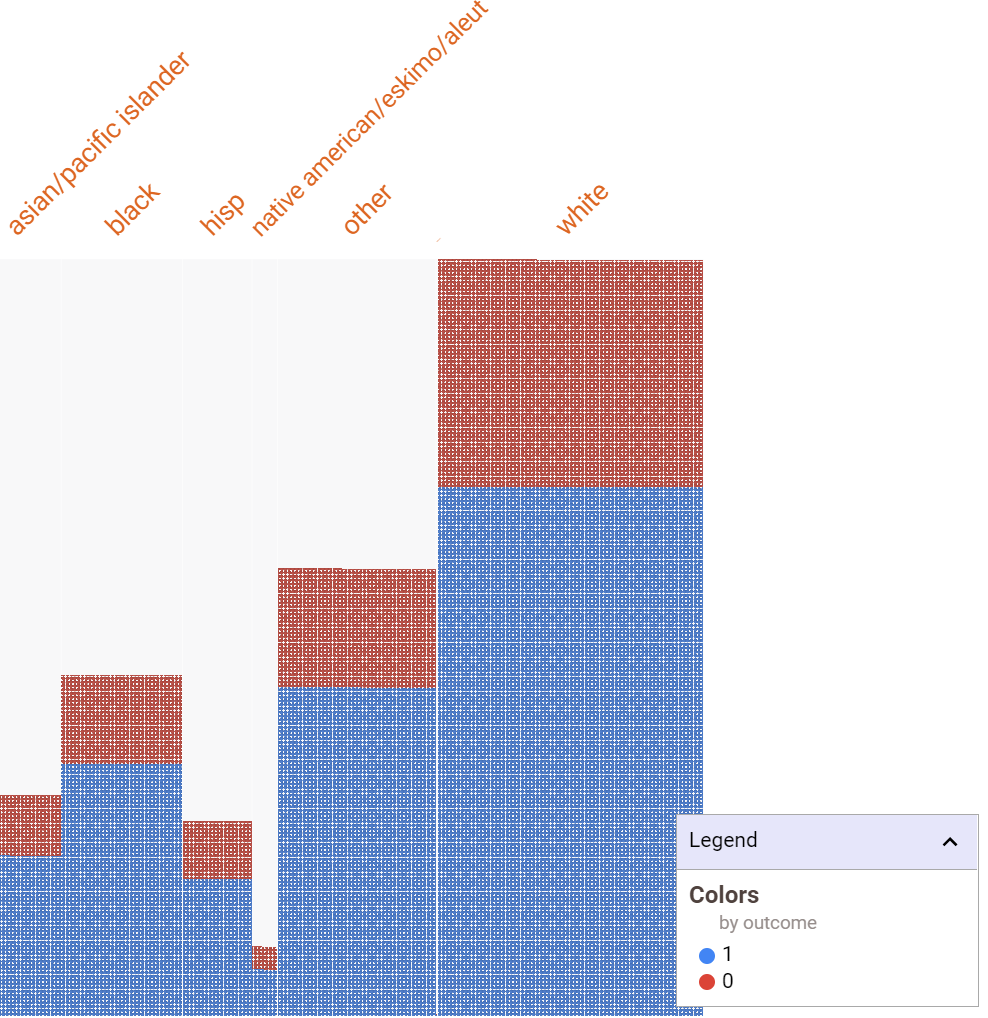

In [62]:
from IPython.display import Image
Image('./images/race_by_outcome.png', width=400)

What can we conclude from the distribution above?

``outcome and mother education``

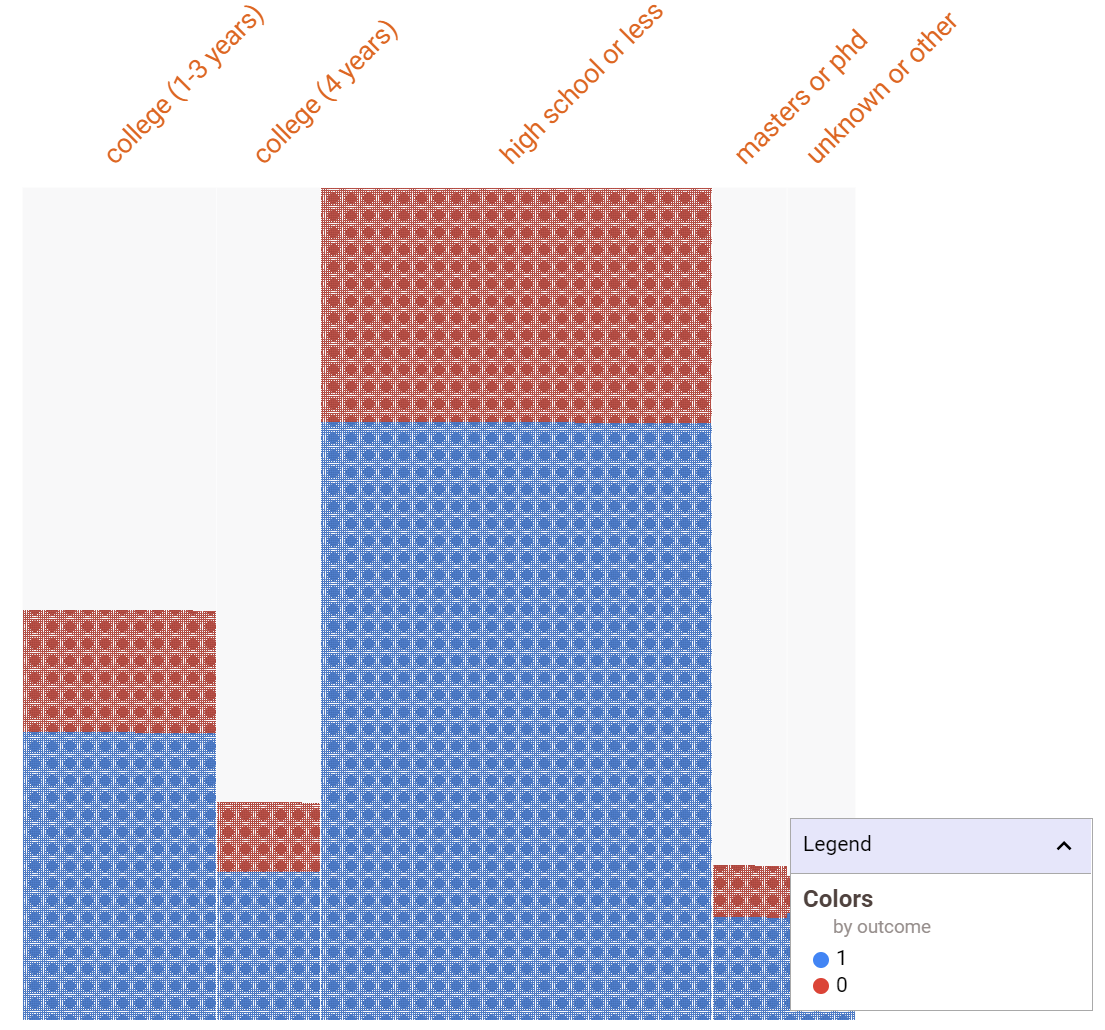

In [28]:
from IPython.display import Image
Image('./images/meduc_by_outcome.png', width=400)

An outcome = 1 (hospital/ER visit is for respiratory/cardio condition) is more prevalent in examples where mother education level is 'High school or less' and 'College (1-3 years)'.

^ With fairness in mind, how would you address the skewed distribution by mother education? Upsample education categories that are underrepresented.

<span style="color:red">Summary: How to make sure unfairness doesn't creep in your data!</span>

- plot, plot, plot: all sorts of plots (histograms, barplots, etc.)
- identify missing data
- rank most-to-least common examples
- make sure training and test sets are similar!


For example, due to the imbalance between males and females in my data, it might be that the prediction algorithm is better at predicting males outcomes as opposed to females! We can prevent this by upsampling the underrepresented group (in this case, women).

``add padding``

check histogram/distribution do decide on **up** (time_steps) parameter

In [29]:
df.groupby('rlnI_updated', as_index=False)['outcome'].count().describe()

outcome
count  73355.000000
mean       4.284657
std        5.164570
min        1.000000
25%        2.000000
50%        3.000000
75%        5.000000
max      146.000000

In [30]:
# add padding
%time df = add_padding(df, lower_bound, upper_bound, time_steps, pad_val)

print('Printing 2 patients in my data after padding...')
df[df.rlnI_updated.isin(('0000OO0NS', '0000OO0OU'))]

CPU times: total: 15min 41s
Wall time: 15min 41s
Printing 2 patients in my data after padding...


Empty DataFrame
Columns: [rlnI_updated, rlnI_key, outcome, age, pm25I_hat, visitsM_9mpp, visitsM_1ypp, visitsI_1yol, M, asian/pacific islander, black, hisp, other, unknown, white, meduc_college (1-3 years), meduc_college (4 years), meduc_high school or less, meduc_unknown or other, patcnty_1.0, patcnty_2.0, patcnty_3.0, patcnty_4.0, patcnty_5.0, patcnty_6.0, patcnty_7.0, patcnty_8.0, patcnty_9.0, patcnty_10.0, patcnty_11.0, patcnty_12.0, patcnty_13.0, patcnty_14.0, patcnty_15.0, patcnty_16.0, patcnty_17.0, patcnty_18.0, patcnty_19.0, patcnty_20.0, patcnty_21.0, patcnty_22.0, patcnty_23.0, patcnty_24.0, patcnty_25.0, patcnty_26.0, patcnty_27.0, patcnty_28.0, patcnty_29.0, patcnty_30.0, patcnty_31.0, patcnty_32.0, patcnty_33.0, patcnty_34.0, patcnty_35.0, patcnty_36.0, patcnty_37.0, patcnty_38.0, patcnty_39.0, patcnty_40.0, patcnty_41.0, patcnty_42.0, patcnty_43.0, patcnty_44.0, patcnty_45.0, patcnty_46.0, patcnty_47.0, patcnty_48.0, patcnty_49.0, patcnty_50.0, patcnty_51.0, patcnty_52.0, patcnty_53.0, patcnty_54.0, patcnty_55.0, patcnty_56.0, patcnty_57.0, patcnty_58.0, cntyresI_1.0, cntyresI_3.0, cntyresI_4.0, cntyresI_5.0, cntyresI_6.0, cntyresI_7.0, cntyresI_8.0, cntyresI_9.0, cntyresI_10.0, cntyresI_11.0, cntyresI_12.0, cntyresI_13.0, cntyresI_14.0, cntyresI_15.0, cntyresI_16.0, cntyresI_17.0, cntyresI_18.0, cntyresI_19.0, cntyresI_20.0, cntyresI_21.0, cntyresI_22.0, cntyresI_23.0, cntyresI_24.0, ...]
Index: []

[0 rows x 245 columns]

``create X and y arrays`` (incl feature Zscore normalization)

In [31]:
# create X and Y arrays
X, y, X_boolmat, y_boolmat, rlnI_key, rlnI_key_boolmat, features = create_X_y_arrays(df, time_steps, pad_val)

``create train, validation and test sets``

In [32]:
# create train, validation and test sets
train_x, train_y, val_x, val_y, test_x, test_y,\
val_x_boolmat, val_y_boolmat, test_x_boolmat, test_y_boolmat, \
train_rlnI, val_rlnI, test_rlnI, val_rlnI_boolmat, test_rlnI_boolmat = split_data(
    X, y, X_boolmat, y_boolmat, rlnI_key, rlnI_key_boolmat, train_split, val_split
)

print("train shapes ",train_x.shape, train_y.shape)
print("val shapes   ", val_x.shape, val_y.shape)
print("test shapes  ", test_x.shape, test_y.shape)
print("Number of features   ", len(features))

train shapes  (51348, 3, 242) (51348, 3, 1)
val shapes    (7335, 3, 242) (7335, 3, 1)
test shapes   (14672, 3, 242) (14672, 3, 1)
Number of features    242


---
### Step 7: More EDA

Here I am interested in investigating my sequence model dataset, in particular, to look at some samples from `train_x`. 

Get the feature called 'age', and generate 20 plots showing how this variable changes over all the timesteps for the first 20 patients (1 time series plot per patient).

Index of feature   0


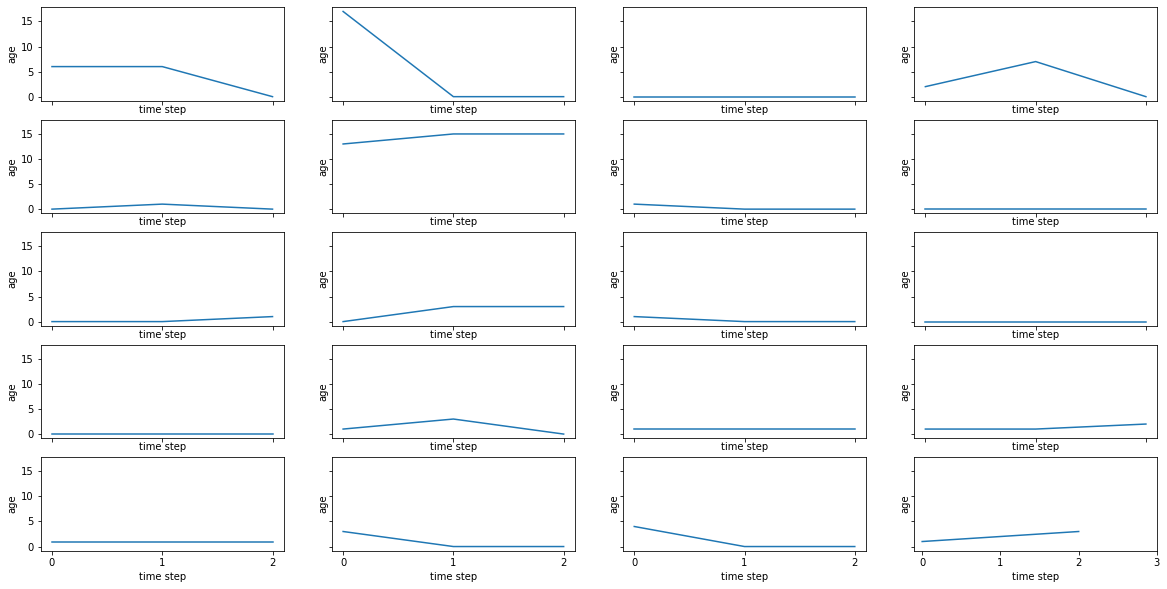

In [33]:
# find index of feature
feature = 'age'
for idx, val in enumerate(features):
    if val==feature:
        idx_feature = idx
        print('Index of feature  ', idx_feature)

# print the first 20 patients
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(20,10), sharey=True, sharex=True)
for idx, ax in enumerate(axes.flatten()):
    ax.plot(pd.DataFrame(train_x[idx]).iloc[:, idx_feature])
    ax.set_ylabel(feature)
    ax.set_xlabel('time step')
    ax.set_xticks([0, 1, 2, 3])
    #ax.set_ylim(0,0.2)

In [34]:
# investigate patient 3 history
pat3 = pd.DataFrame(train_x[3])
pat3.columns=features
pat3

age  pm25I_hat  visitsM_9mpp  visitsM_1ypp  visitsI_1yol    M  \
0  2.0   8.785691           0.0           0.0           1.0  1.0   
1  7.0   9.760620           0.0           0.0           1.0  1.0   
2  0.0   0.000000           0.0           0.0           0.0  0.0   

   asian/pacific islander  black  hisp  other  ...  diag_V8  diag_V9  diag_16  \
0                     0.0    0.0   0.0    0.0  ...      0.0      0.0      0.0   
1                     0.0    0.0   0.0    0.0  ...      0.0      0.0      0.0   
2                     0.0    0.0   0.0    0.0  ...      0.0      0.0      0.0   

   diag_63  diag_65  diag_66  diag_Z9  diag_14  diag_N3  diag_Q6  
0      0.0      0.0      0.0      0.0      0.0      0.0      0.0  
1      0.0      0.0      0.0      0.0      0.0      0.0      0.0  
2      0.0      0.0      0.0      0.0      0.0      0.0      0.0  

[3 rows x 242 columns]

By looking at these graphs (carefully read the data preprocessing steps as well):
    
* Why are the last values in the series usually 0, and why do some reach 0 earlier than others? <br>

Answer: 0 means the padding kicked in for a given patient. Some reach 0 earlier than others depending on how long the patient sequence is before padding.

---
### Step 8: LSTM prediction model

My data inputs are features related to the patient and the prediction output is wheather the next hospital/ER visit is for respiratory/cardio conditions or injuries/accidents. I will attemt a many-to-many problem first and then a many-to-one.

**define an LSTM**

I'll use an LSTM model to predict a patient outcome at each time step. So each data point I pass to the model will be a sequence of length `n_timesteps`, where each timestamp has `k` features. My prediction output is also a sequence of length `n_timesteps`. 

Using Keras  `Sequential`, I define a model called `model_lstm`. It has:
- 1 LSTM layer with 200 units. Use the default activation for the LSTM layer. Keras has optimized GPU implementations for most layers, but it does not have an optimized implementation for LSTM with non-default activations.
- 1 dropout layer with `rate=0.5`.
- 1 dense layer that applies the same tranformation to each of the prediction outputs. 
- A suitable activation function for the prediction task. 

In [35]:
def build_lstm_model(len_features):
    """
    Return a simple Keras model with a single LSTM layer, dropout later, 
    and then dense prediction layer.
    
    Args:
    lstm_hidden_units (int): units in the LSTM layer    
    
    Returns:
    model_lstm (tf.keras.Model) LSTM keras model with output dimension (None,1)
    """
    
    tf.keras.backend.clear_session()
    tf.random.set_seed(1234)
    
    model_lstm = None
    
    # instanntiate model
    model_lstm = tf.keras.Sequential()
    
    # add layers
    model_lstm.add(Bidirectional(LSTM(
        units=200,
        #recurrent_dropout=0.4,
        #use_bias=True,
        return_sequences=True,
        name='LSTM1'), name='bidir-LSTM1'))    
    
    model_lstm.add(Dropout(
        rate=0.5,
        name='Dropout1'
    ))
    
    # add layers
    model_lstm.add(Dense(
        units=64,
        activation='relu',
        name='Dense1'
    ))
    
    
    model_lstm.add(Dense(
        units=1,
        activation='sigmoid',
        name='Dense2'))
    
    model_lstm.build(input_shape=(None, None, len_features))

    
    model_lstm.summary()

    # END CODE #
    return model_lstm

In [36]:
features_len = len(features)
model_lstm = build_lstm_model(features_len)
output = model_lstm(train_x)
#output

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidir-LSTM1 (Bidirectional)  (None, None, 400)        708800    
                                                                 
 Dropout1 (Dropout)          (None, None, 400)         0         
                                                                 
 Dense1 (Dense)              (None, None, 64)          25664     
                                                                 
 Dense2 (Dense)              (None, None, 1)           65        
                                                                 
Total params: 734,529
Trainable params: 734,529
Non-trainable params: 0
_________________________________________________________________


In [37]:
# define metrics
METRICS = [
      #keras.metrics.TruePositives(name='tp'),
      #keras.metrics.FalsePositives(name='fp'),
      #keras.metrics.TrueNegatives(name='tn'),
      #keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      #keras.metrics.Precision(name='precision'),
      #keras.metrics.Recall(name='recall'),
      #keras.metrics.AUC(name='auc'),
      #keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [38]:
## compile and train:
model_lstm.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=METRICS
)

# Train model
history = model_lstm.fit(x=train_x,
                y=train_y,
                validation_split=0.1, # set 10% of train data for validation
                epochs=15,
                verbose=1, #silence fit
                #callbacks=[tensorboard_callback]
)

Epoch 1/15
1445/1445 [==============================] - 21s 13ms/step - loss: 0.3388 - accuracy: 0.8389 - val_loss: 0.3141 - val_accuracy: 0.8535
Epoch 2/15
1445/1445 [==============================] - 20s 14ms/step - loss: 0.3064 - accuracy: 0.8577 - val_loss: 0.3068 - val_accuracy: 0.8582
Epoch 3/15
1445/1445 [==============================] - 20s 14ms/step - loss: 0.3004 - accuracy: 0.8599 - val_loss: 0.3061 - val_accuracy: 0.8567
Epoch 4/15
1445/1445 [==============================] - 20s 14ms/step - loss: 0.2968 - accuracy: 0.8626 - val_loss: 0.3048 - val_accuracy: 0.8599
Epoch 5/15
1445/1445 [==============================] - 20s 14ms/step - loss: 0.2933 - accuracy: 0.8637 - val_loss: 0.3018 - val_accuracy: 0.8597
Epoch 6/15
1445/1445 [==============================] - 20s 14ms/step - loss: 0.2906 - accuracy: 0.8656 - val_loss: 0.3004 - val_accuracy: 0.8607
Epoch 7/15
1445/1445 [==============================] - 20s 14ms/step - loss: 0.2877 - accuracy: 0.8663 - val_loss: 0.3043 -

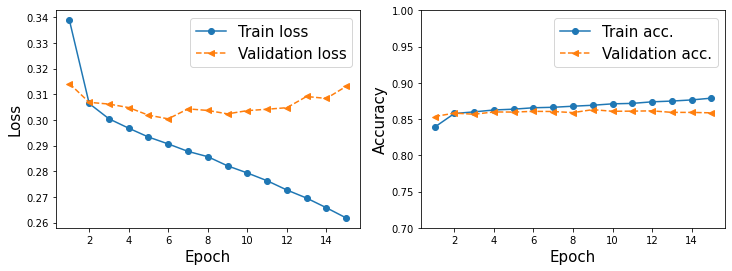

In [39]:
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
ax.set_ylim(0.7,1)
plt.show()

### Show what the NN model is learning after each layer

In [40]:
tensor = np.expand_dims(train_x[2], axis = 0);
display(pd.DataFrame(train_x[2]))
print('Outcome\n', train_y[2])

0          1    2    3    4    5    6    7    8    9    ...  232  233  234  \
0  0.0  10.570150  0.0  0.0  8.0  1.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
1  0.0  10.011514  0.0  0.0  8.0  1.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
2  0.0   0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   

   235  236  237  238  239  240  241  
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[3 rows x 242 columns]

Outcome
 [[1.]
 [0.]
 [0.]]


``print layers``

In [41]:
layers = [layer.output for layer in model_lstm.layers[:4]]
layers

[<KerasTensor: shape=(None, None, 400) dtype=float64 (created by layer 'bidir-LSTM1')>,
 <KerasTensor: shape=(None, None, 400) dtype=float64 (created by layer 'Dropout1')>,
 <KerasTensor: shape=(None, None, 64) dtype=float64 (created by layer 'Dense1')>,
 <KerasTensor: shape=(None, None, 1) dtype=float64 (created by layer 'Dense2')>]

``activation model``

In [42]:
activation_model = tf.keras.models.Model(inputs = model_lstm.input, outputs = layers)
activation_model

``learned activations for each layer``

In [43]:
activations = activation_model.predict(tensor)

## print to see what are the learned activations ##
##################################################
# original example
print('Feature values original example:')
display(pd.DataFrame(tf.squeeze(train_x[2]).numpy()))

print('\nLearned activations first layer (should be the same as the original example, nothing to learn yet):')
display(pd.DataFrame(tf.squeeze(activations[0]).numpy()))

print('\nLearned activations second layer :')
display(pd.DataFrame(tf.squeeze(activations[1]).numpy()))
        
print('\nLearned activations third layer :')
display(pd.DataFrame(tf.squeeze(activations[2]).numpy()))

print('\nLearned activations fourth layer :')
display(pd.DataFrame(tf.squeeze(activations[3]).numpy()))

1/1 [==============================] - 0s 482ms/step
Feature values original example:


0          1    2    3    4    5    6    7    8    9    ...  232  233  234  \
0  0.0  10.570150  0.0  0.0  8.0  1.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
1  0.0  10.011514  0.0  0.0  8.0  1.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
2  0.0   0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   

   235  236  237  238  239  240  241  
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[3 rows x 242 columns]


Learned activations first layer (should be the same as the original example, nothing to learn yet):


0         1         2         3         4         5         6    \
0  0.006974  0.026099  0.024330  0.033374 -0.150838  0.025655  0.000803   
1  0.033320  0.046675  0.043187  0.030738 -0.194082  0.022459  0.022032   
2  0.102061  0.301230  0.159367  0.200857 -0.225632 -0.446920  0.133005   

        7         8         9    ...       390       391       392       393  \
0 -0.020475  0.045200 -0.003531  ... -0.068586  0.001966 -0.164579 -0.074878   
1 -0.000918  0.100232  0.136218  ...  0.162402 -0.004747  0.154474  0.340613   
2  0.017631  0.063107  0.128920  ...  0.003448 -0.034202 -0.019140 -0.017026   

        394       395       396       397       398       399  
0 -0.004192  0.042548 -0.012028 -0.039495  0.027096  0.002872  
1  0.018386  0.006918  0.009696  0.000228  0.010056 -0.009706  
2 -0.006905 -0.008487  0.019323  0.037700  0.064695 -0.025047  

[3 rows x 400 columns]


Learned activations second layer :


0         1         2         3         4         5         6    \
0  0.006974  0.026099  0.024330  0.033374 -0.150838  0.025655  0.000803   
1  0.033320  0.046675  0.043187  0.030738 -0.194082  0.022459  0.022032   
2  0.102061  0.301230  0.159367  0.200857 -0.225632 -0.446920  0.133005   

        7         8         9    ...       390       391       392       393  \
0 -0.020475  0.045200 -0.003531  ... -0.068586  0.001966 -0.164579 -0.074878   
1 -0.000918  0.100232  0.136218  ...  0.162402 -0.004747  0.154474  0.340613   
2  0.017631  0.063107  0.128920  ...  0.003448 -0.034202 -0.019140 -0.017026   

        394       395       396       397       398       399  
0 -0.004192  0.042548 -0.012028 -0.039495  0.027096  0.002872  
1  0.018386  0.006918  0.009696  0.000228  0.010056 -0.009706  
2 -0.006905 -0.008487  0.019323  0.037700  0.064695 -0.025047  

[3 rows x 400 columns]


Learned activations third layer :


0         1         2        3    4         5         6    7    8   \
0  0.0  0.931526  1.192154  0.00000  0.0  2.017281  0.000000  0.0  0.0   
1  0.0  0.000000  0.000000  0.00000  0.0  1.296915  0.000000  0.0  0.0   
2  0.0  0.000000  0.000000  1.64291  0.0  0.100042  0.633133  0.0  0.0   

         9   ...   54   55   56        57   58        59        60   61  \
0  0.000000  ...  0.0  0.0  0.0  0.084761  0.0  0.535455  0.000000  0.0   
1  0.000000  ...  0.0  0.0  0.0  0.000000  0.0  0.000000  0.000000  0.0   
2  2.140806  ...  0.0  0.0  0.0  0.000000  0.0  0.000000  2.036085  0.0   

         62   63  
0  0.000000  0.0  
1  0.964990  0.0  
2  1.525415  0.0  

[3 rows x 64 columns]


Learned activations fourth layer :


0
0  9.604506e-01
1  5.548200e-01
2  7.603512e-07

In [44]:
# Show learned model
#w = model_lstm.layers[0].get_weights()[0]
#b = model_lstm.layers[0].get_weights()[1]

#print('Bias:', b)
#print('Weights', w.shape)

---
### Step 9: Evaluation with <span style="color:chocolate">fairness</span> in mind

(on the test dataset)

Evaluating the overall performance of the model gives us some insight into its quality, but it doesn't give us much insight into how well our model performs for **different subgroups**.

When evaluating a model for fairness, it's important to determine whether prediction errors are uniform across subgroups or whether certain subgroups are more susceptible to certain prediction errors than others.

In [45]:
# run the trained model on the test data (the model outputs probabilities)
test_y_pred = model_lstm.predict(x=test_x).flatten()

# apply the threshold function to create a 0, 1 outcome
threshold = 0.5
test_y_pred_bin = np.where(test_y_pred>=threshold, 1, 0)
test_y_pred_bin[0:8]

459/459 [==============================] - 3s 5ms/step


array([0, 0, 0, 0, 1, 0, 1, 1])

Some of the predictions should be masked, and therefore removed from the final prediction dataset. In the next cell I will use `test_y_pred_bin` and `test_y_boolmat` to create the vectors `test_y_pred_nomask_bin` and `test_y_nomask` by removing the masked predictions, and flattening the output.

In [46]:
# collect only predictions for non-masked values
test_y_pred_nomask_bin = test_y_pred_bin[test_y_boolmat.flatten()==False] # False removes masked values
test_y_pred_nomask = test_y_pred[test_y_boolmat.flatten()==False]
test_y_nomask = test_y.flatten()[test_y_boolmat.flatten()==False] 

``confusion matrix``

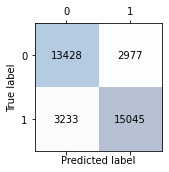

In [47]:
conf_matrix = tf.math.confusion_matrix(
    #test_y.flatten(),
    #test_y_pred_bin,
    test_y_nomask,
    test_y_pred_nomask_bin,
    num_classes=None,
    weights=None,
    dtype=tf.dtypes.int32,
    name=None
)
plots.confusion_matrix_plot(conf_matrix.numpy())

### <span style="color:chocolate">FairAware Task #3</span>

Generate confusion matrices for:
- the two gender subgroups: males vs. females
- different age groups
- different race groups: e.g., black vs. white, hispanic vs. white
- different mother education categories

Compare the number of False Positives and False Negatives for each subgroup. Are there any significant disparities in error rates that suggest the model performs better for one subgroup than another?

In [ ]:
# YOUR CODE HERE

``recall``

In [49]:
# note that TensorFlow assumes that the positive class is output = 1
r = tf.keras.metrics.Recall(
    thresholds=None, top_k=None, class_id=None, name=None, dtype=None
)
r.update_state(
    #test_y.flatten(),
    #test_y_pred,
    test_y_nomask,
    test_y_pred_nomask_bin,
    
)
print("Recall score: %.3f" %r.result().numpy())

Recall score: 0.823


``ROC AUC``

This plot is useful because it shows, at a glance, the range of performance the model can reach just by tuning the output threshold. Plots fpr vs. tpr for diffrent thresholds

ROC AUC   0.9038779930364652


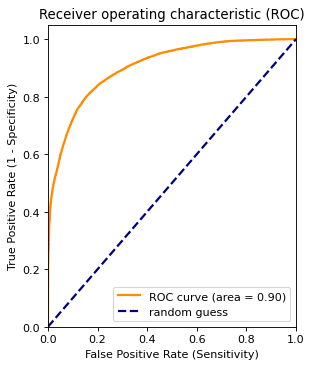

In [50]:
fpr , tpr , thresholds_roc = roc_curve(
    #test_y.flatten(),
    #test_y_pred
    test_y_nomask,
    test_y_pred_nomask,
)

# roc auc
roc_auc = auc(fpr, tpr)
print('ROC AUC  ', roc_auc)
plots.plot_roc(fpr, tpr, roc_auc)

``Matthews corr coef``

In [51]:
mcc = matthews_corrcoef(
    #test_y.flatten(),
    #test_y_pred_bin
    test_y_nomask,
    test_y_pred_nomask_bin,
)

print("Matthews correlation coef   ", np.round(mcc,4))

Matthews correlation coef    0.6412


---
### Step 9: Counterfactual analysis with <span style="color:chocolate">fairness</span> in mind

``compute counterfactual predictions``

In [52]:
test_df_nomask = plots.test_counterfactuals(df, test_rlnI, test_rlnI_boolmat, test_x, test_y, test_y_boolmat, model_lstm)
test_df_nomask.head()

Compute predictions for PM25Ihat level:  1
459/459 [==============================] - 3s 6ms/step
Compute predictions for PM25Ihat level:  0.99
459/459 [==============================] - 3s 6ms/step
Compute predictions for PM25Ihat level:  0.7
459/459 [==============================] - 3s 6ms/step
Compute predictions for PM25Ihat level:  0.3
459/459 [==============================] - 3s 6ms/step
Compute predictions for PM25Ihat level:  0
459/459 [==============================] - 3s 6ms/step


rlnI_updated  rlnI_key  visitsI_1yol  age    M  white  black  hisp  \
3     000HYEWEH      12.0           2.0  0.0  0.0    1.0    0.0   0.0   
4     000HYEWEH      12.0           2.0  1.0  0.0    1.0    0.0   0.0   
5     000HYEWEH      12.0           2.0  1.0  0.0    1.0    0.0   0.0   
30    001SIS0R1      47.0           2.0  0.0  1.0    1.0    0.0   0.0   
31    001SIS0R1      47.0           2.0  0.0  1.0    1.0    0.0   0.0   

    pm25I_hat  outcome  outcome_pp_1  outcome_pred_1  outcome_pp_0.99  \
3    8.825130      1.0      0.016467               0         0.016214   
4    9.062638      1.0      0.488945               0         0.488406   
5    8.906491      1.0      0.906580               1         0.908808   
30  15.687922      1.0      0.411138               0         0.408334   
31  15.716335      1.0      0.998449               1         0.998524   

    outcome_pred_0.99  outcome_pp_0.7  outcome_pred_0.7  outcome_pp_0.3  \
3                   0        0.009925                 0        0.004319   
4                   0        0.465808                 0        0.331191   
5                   1        0.962578                 1        0.992557   
30                  0        0.323297                 0        0.190872   
31                  1        0.999685                 1        0.999969   

    outcome_pred_0.3  outcome_pp_0  outcome_pred_0  
3                  0      0.001877               0  
4                  0      0.026983               0  
5                  1      0.981691               1  
30                 0      0.017246               0  
31                 1      0.999993               1

``plot pm25 counterfactual probability changes``

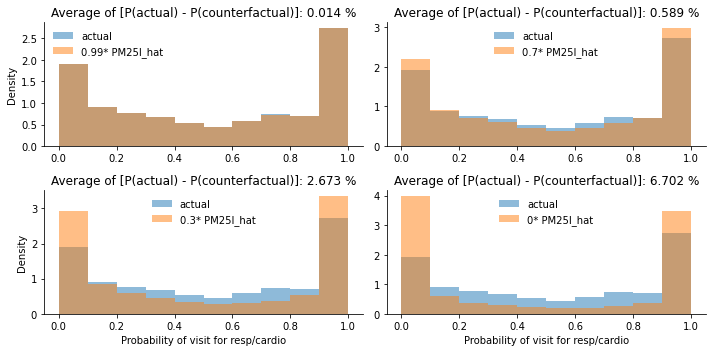

In [53]:
plots.plot_counterfactuals_pm(test_df_nomask)

``plot pm25 counterfactual probability changes by sex and race``

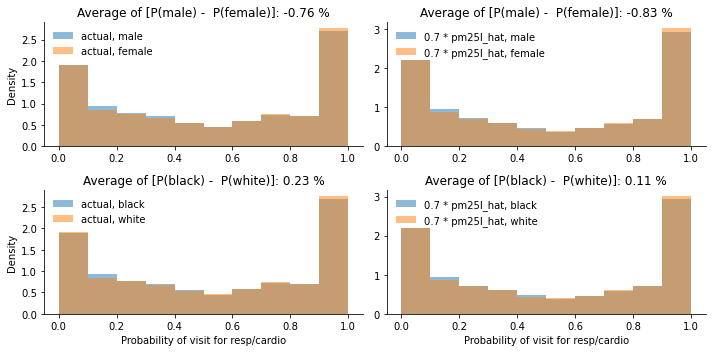

In [54]:
plots.plot_counterfactuals_pm_race_sex(test_df_nomask)

``plot pm25 counterfactual counts(visit) changes``

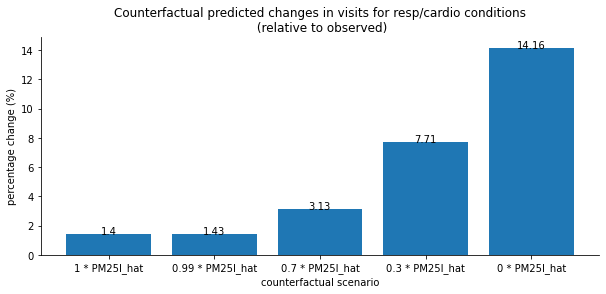

In [55]:
plots.plot_counterfactuals_counts(test_df_nomask)

Assuming our model predictions are close to ground truth (they are not just yet, we overpredict the positive class by 1.4% in the test set), then:

for 30% reduction in pollution exposure (pm25_hat) you get 3.3%  decrease in hospital visits for resp/cardio conditions and this is equivalent to a XXX reduction in cost.

``plot predicted vs. actual counts (visits) by demographics``

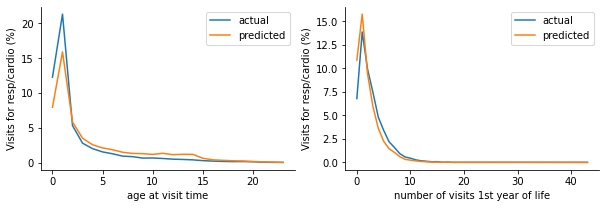

In [57]:
plots.plot_counts_pred_vs_actual_age_1yol(test_df_nomask)

What can we conclude from the plot above?

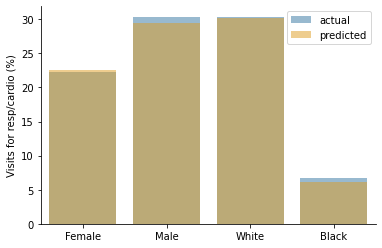

In [58]:
plots.plot_counts_pred_vs_actual_demo(test_df_nomask)

What can we conclude from the plot above?